In [ ]:
#  ! pip install -r packages.txt -i https://pypi.tuna.tsinghua.edu.cn/simple


In [6]:
%matplotlib inline
import os
from os.path import join as pjoin
from tifffile import imread, imwrite
import numpy as np
import shutil
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from tqdm import tqdm
from wf_utils import *

In [9]:
### Set the file path

# path_0: including one-day recording files
# path_1: including every stimuli
path_0 = "Y:\\WF_VC_liuzhaoxi\\23.11.23_C83"
path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

print('All the file path:\n'+str(path_all))


All the file path:
['Y:\\WF_VC_liuzhaoxi\\23.11.23_C83\\retinotopy']


In [10]:
### re-organize files

for path in path_all:
    if not os.path.exists(pjoin(path, 'raw')):
        os.mkdir(pjoin(path, 'raw'))
    if not os.path.exists(pjoin(path, 'process/')):
        os.mkdir(pjoin(path, 'process/'))
        
for path in path_all:
    files = glob(pjoin(path, '202?????-??????*'))
    for file in files:
        shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
        print('moving',file)

print('Moving raw data folders all finished!')


moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129-405
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129-405.tif
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129-405Timestamp.csv
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129-470
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129-470.tif
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129-470Timestamp.csv
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129-event
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-142129.csv
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-143718-405
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-143718-405.tif
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-143718-405Timestamp.csv
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-143718-470
moving Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\20231123-143718-470.tif
moving Y:\WF_VC_liuzhaoxi\23.11.2

Path: Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy
experiments:
['20231123-143718', '20231123-142129']
importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-143718-405.tif
finish importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-143718-405.tif
importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-143718-470.tif
finish importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-143718-470.tif


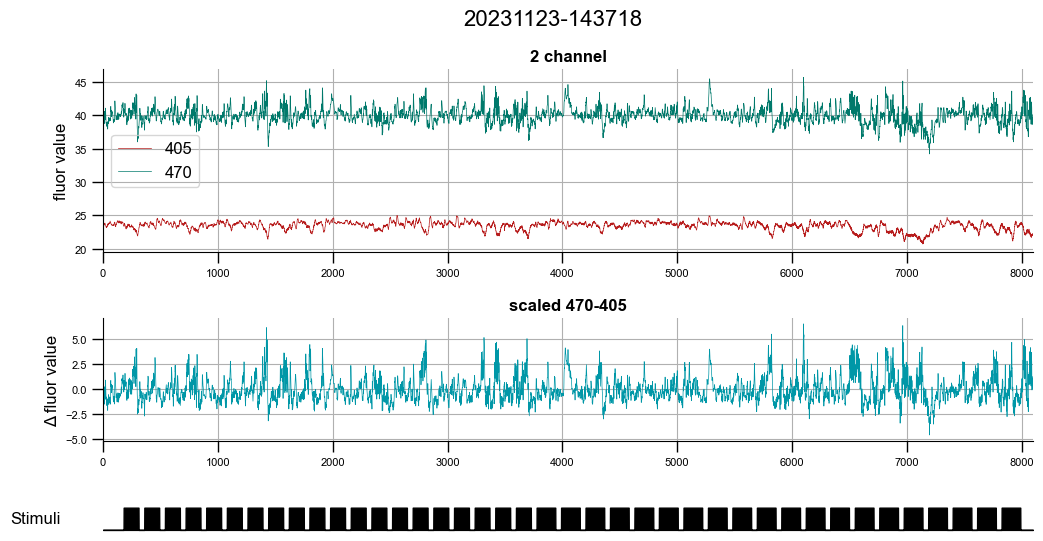

importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-142129-405.tif
finish importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-142129-405.tif
importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-142129-470.tif
finish importing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\raw\20231123-142129-470.tif


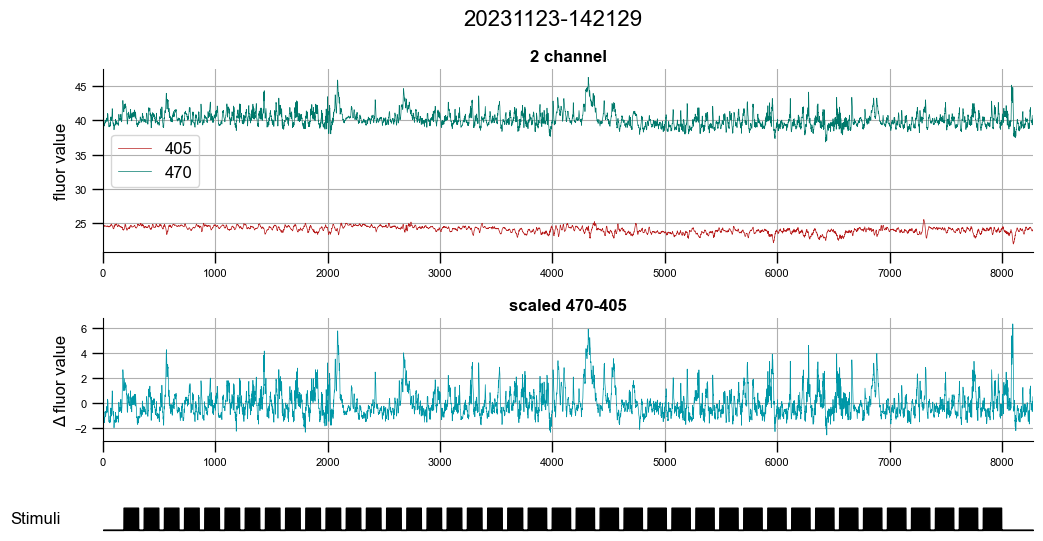


finished Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy


All merging finished!


In [12]:
### generate 2-channel tif stack

cropsize = (120, 140, 256, 256)  # (left, top, width, height)

def filename2int(x):
    # 从文件名中提取整数值，用于后续排序等。
    filename = os.path.splitext(os.path.basename(x))[0]
    return int(filename)

def organize_tif(folder_path):
    folder_name = os.path.basename(folder_path)
    if os.path.exists(folder_path+'.tif'):
        print('importing {}.tif'.format(folder_path))
        image_stack = imread(folder_path+'.tif')
        print('finish importing {}.tif'.format(folder_path))
    else:
        tiffiles = [pjoin(folder_path, tifname) for tifname in os.listdir(folder_path) if tifname.endswith((".tif", ".tiff"))]
        tiffiles = sorted(tiffiles, key = filename2int) # 确保图像帧按顺序排列
        image_stack = [imread(tiff) for tiff in log_progress(tiffiles, name=folder_name)]  # 将多帧tif堆叠成数组
    left, top, width, height = cropsize
    cropped_images = [frame[top:top+height, left:left+width] for frame in image_stack]  # 裁剪图像
    rotated_images = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in cropped_images]   # 顺时针旋转图像90度
    # 计算并保存均值数据
    mean_values = [np.mean(frame) for frame in cropped_images]
    output_value = pjoin(processPath, folder_name + "-Values.csv")
    np.savetxt(output_value, mean_values, delimiter=",")
    return np.array(rotated_images)


for path in path_all:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = os.listdir(rawPath)
    experiments = list(set([item[:15] for item in items if os.path.isdir(pjoin(rawPath, item))]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-wfield"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-wfield")
        merge_file = pjoin(mergePath, experiment+"-merged.tif")
        if not os.path.exists(merge_file):
            tif_405 = organize_tif(pjoin(rawPath, experiment + "-405"))
            tif_470 = organize_tif(pjoin(rawPath, experiment + "-470"))
            # 检查两个通道的深度是否一致
            if tif_405.shape[0] != tif_470.shape[0]:
                n_frames = min(tif_405.shape[0], tif_470.shape[0])
                tif_405 = tif_405[:n_frames]
                tif_470 = tif_470[:n_frames]
            # 将Tiff stack的数据从三维变成四维，不同通道使用第二维区分
            merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
            # 将合并后的图像保存为一个2通道Tiff图像
            imwrite(merge_file, merged_tif, imagej=True)
                        
        else: print("merged "+experiment+" has existed")
        plotFluor(path, experiment)
        
    print("\nfinished "+ path+"\n\n")
    
print("All merging finished!")


### ********************************************************************************************************************
### 从这里开始用wfield软件做运动矫正、奇异值分解、血流动力学矫正。以下必须用wfield环境！！！
### ********************************************************************************************************************

In [13]:
%matplotlib inline
from glob import glob
import os
from os.path import join as pjoin
import subprocess
from wfield_utils import *

In [14]:
# try wfield

! wfield -h

usage: wfield <command> [<args>]

The commands are:
    ncaas               Opens a gui to launch data on the neuroCAAS platform
    open                Opens a gui to look at the preprocessed data        
    open_raw            Opens a gui to look at the raw frames
    preprocess          Preprocess data in binary fornat
    motion              Registers data from a binary file
    decompose           Performs single value decomposition
    correct             Performs hemodynamic correction on dual channel data
    imager              
    imager_preprocess   Preprocesses data recorded with the WidefieldImager

wfield - tools to process widefield data

positional arguments:
  command     type wfieldtools <command> -h for help

options:
  -h, --help  show this help message and exit


In [15]:
# 列出所有已经合并通道的tiff的路径

path_wfield_all = glob(pjoin(path_0, '*\\process\\*-wfield'))
print('All the wfield-path:\n'+"\n".join(path_wfield_all))


All the wfield-path:
Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\process\20231123-142129-wfield
Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\process\20231123-143718-wfield


In [16]:
### 生成trial_onsets.npy

nbaseline_frames = 30 #预留的刺激前frames，用来计算baseline

for path_wfield in path_wfield_all:
    if 'retinotopy' in path_wfield:
        experiment = os.path.basename(path_wfield)[:15]
        rawPath = pjoin(path_wfield,'../../raw')
        
        # generate trial_onsets.npy
        # trial_onsets.npy is a Nx3 array. The columns are: trial number, onset of the trial (frame index), offset of the trial.
        if not os.path.exists(pjoin(path_wfield, 'trial_onsets.npy')):
            n_frame = min(len(os.listdir(pjoin(rawPath, experiment + "-405"))), 
                          len(os.listdir(pjoin(rawPath, experiment + "-470"))))
            stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
            stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
            stim_delay = int(stim_delay[0]/10)
            
            stim = np.zeros(n_frame)
            for i in range(n_frame):
                stim[i] = stimfile[(i * 10 + stim_delay), 0]
            single_0_indices = np.where((np.diff(np.append(stim, 0)) == 1) & (np.diff(stim, prepend=0) == -1))[0]
            single_1_indices = np.where((np.diff(np.append(stim, 0)) == -1) & (np.diff(stim, prepend=0) == 1))[0]
            stim[single_1_indices] = 0
            stim[single_0_indices] = 1
            
            onset = np.where(np.diff(stim) == 1)[0] + 1
            offset = np.where(np.diff(stim) == -1)[0] + 1
            trial_onsets = np.stack((np.arange(len(onset)), onset - nbaseline_frames, offset), axis=1)  # 这个文件给wfield软件做SVD用
            np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)
            trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset-onset), axis=1)  # 这个用来自己检查一下以及自己后续分析
            np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
            print("generate trial_onsets.npy of "+experiment)
            
        else: print("trial_onsets.npy of "+experiment+" has existed")
            
print("\nAll generation of trials-file finished!")


trial_onsets.npy of 20231123-142129 has existed
trial_onsets.npy of 20231123-143718 has existed

All generation of trials-file finished!


In [17]:
# 用wfield进行Motion correction, single value decomposition, hemodynamic correction。

# nbaseline_frames = 30 

for path_wfield in path_wfield_all:
    if len(glob(pjoin(path_wfield, '*-merged.tif'))) == 0:
        print(path_wfield,"can't find merged tiff file！\n")
    elif len(glob(pjoin(path_wfield, '*-merged.tif'))) > 1:
        print(path_wfield,"exist multiple merged tiff file！\n")
    elif os.path.exists(pjoin(path_wfield, 'SVTcorr.npy')):
        print(path_wfield,'analysis has been finished！\n')
    else:
        print('Start analyze',path_wfield)
        command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_wfield,path_wfield)
        logfile = pjoin(path_wfield, 'log.txt')
        with open(logfile, "w") as log:
            result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
            log.write(result.stdout)
        if result.returncode == 0:
            print('Finish analyzing',path_wfield,'\n')
        else:
            print('！！！Error occured when analyzing',path_wfield,'\n')
        
print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')


Start analyze Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\process\20231123-142129-wfield
Finish analyzing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\process\20231123-142129-wfield 
Start analyze Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\process\20231123-143718-wfield
Finish analyzing Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\process\20231123-143718-wfield 


Motion correction, single value decomposition, hemodynamic correction. All finished!


In [ ]:
# 重构矫正后图像

export_corr_tif = False

if export_corr_tif is True:
    for path_wfield in path_wfield_all:
        print('\npath', path_wfield)
        filename = os.path.basename(glob(pjoin(path_wfield, '*-merged.tif'))[0])[:16]
        if not (os.path.exists(pjoin(path_wfield, filename+"SVD_corr.tif")) or os.path.exists(pjoin(path_wfield, filename+"SVD_corr_uint16.tif")) or os.path.exists(pjoin(path_wfield, filename+"hemo-corr.tif"))):
            svd2tif(path_wfield, name=filename, uint16=False, corr470=False)
        else:
            print('reconstruction has been finished！')
        
    print('\n\nAll image reconstruction finished!')


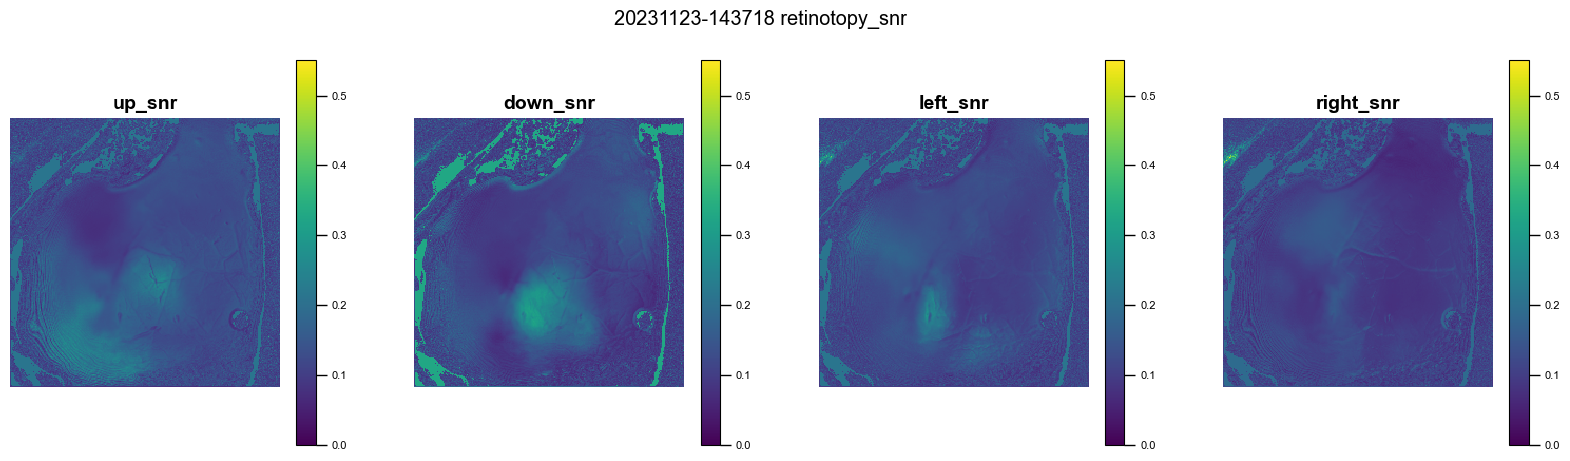

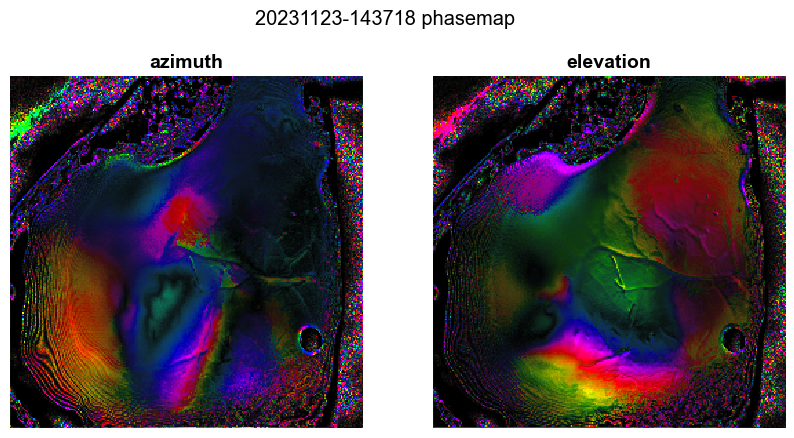

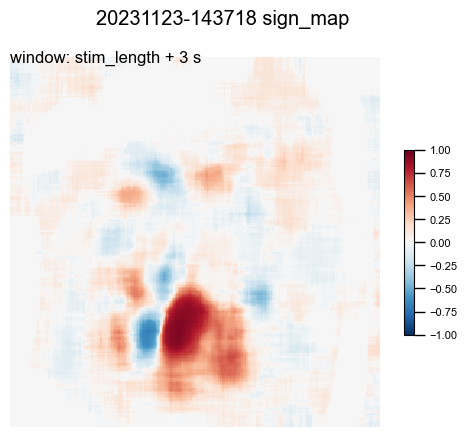

In [2]:
from wfield_utils import *

phasemap(r'Y:\WF_VC_liuzhaoxi\23.11.23_C83\retinotopy\process\20231123-143718-wfield', 
         nrepeats=10, post_trial=3, export_ave_tif=False, export_raw_tif=False, 
         plot_snr=True, plot_phasemasp=True, export_phase=False)
